# 20152410 배형준 머신러닝 과제7

In [1]:
# library import

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# set my local working directory

import os

directory = 'C:\\Users\\golds\\Desktop\\중앙대학교\\2020-1 4학년 1학기\\머신러닝'
os.chdir(directory)

# 1. Plot the training data

In [3]:
# load dataset

filename = './과제7/data-nonlinear.txt'
train = pd.read_csv(filename, header=None)
train.columns = ['x', 'y', 'l']

label_0 = train.loc[train['l'] == 0, :]
label_1 = train.loc[train['l'] == 1, :]

X = np.array(train[['x', 'y']])
label = np.array(train['l']).reshape(-1, 1)

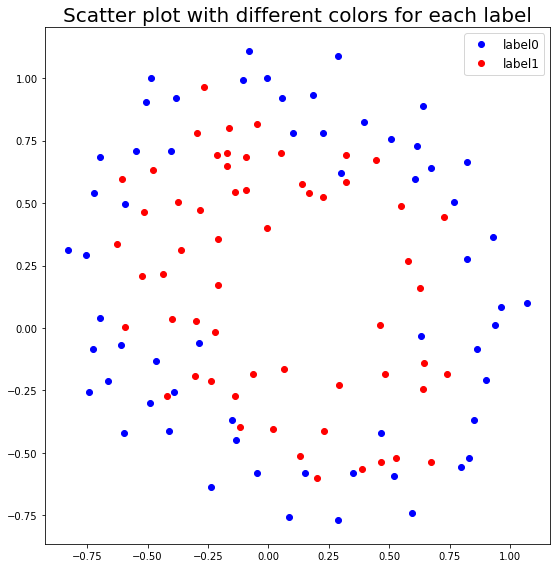

In [4]:
# scatter plot with different colors for each label

plt.figure(figsize=(8, 8))
plt.plot(label_0.x, label_0.y, 'bo', label='label0')
plt.plot(label_1.x, label_1.y, 'ro', label='label1')

plt.legend(loc='best', fontsize=12)
plt.title('Scatter plot with different colors for each label', fontsize=20)

plt.tight_layout()
plt.show()

## Implement polynomial ridge logistic regression

In [5]:
class make_polynomial:
    def __init__(self, degree=2):
        self.degree = degree
    
    def transform(self, X):
        X = np.array(X)
        degree_list = []
        
        for j in range(self.degree+1):
            for i in range(self.degree+1):
                degree_list.append((i, j))
        
        name = ['x^{}*y^{}'.format(degree_list[i][0], degree_list[i][1]) for i in range(len(degree_list))]
        poly = np.zeros((X.shape[0], len(degree_list)))
        
        for i in range(len(degree_list)):
            poly[:, i] = X[:, 0]**(degree_list[i][0]) * X[:, 1]**(degree_list[i][1])
        
        return pd.DataFrame(poly, columns=name)

In [6]:
class standardscaler:
    def __init__(self):
        self.mean = 0
        self.std = 0
    
    def fit(self, X):
        X = np.array(X)
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
        return self

    def transform(self, X):
        X = np.array(X)
        X_scaled = np.zeros(X.shape)
        X_scaled[:, 0] = np.ones(X_scaled[:, 0].shape)
        
        for i in range(1, X.shape[1]):
            temp = (X[:, i] - self.mean[i]) / self.std[i]
            X_scaled[:, i] = temp
        
        return X_scaled

In [7]:
# 이제까지 def로만 해봤는데 class로도 해보고 싶어서 새로운 시도를 한다!

class logistic_regression:
    def __init__(self, learning_rate=0.01, error_bound=10**(-8), critical_value=0.5, iteration=1000, alpha=1):
        self.learning_rate = learning_rate
        self.error_bound = error_bound
        self.critical_value = critical_value
        self.iteration = iteration
        
        self.coef_ = 0
        self.record_coef = 0
        self.record_cost = []
        self.record_accuracy = []
        self.alpha = alpha
        
    def sigmoid(self, X, theta):
        z = np.dot(X, theta)
        
        return 1 / (1 + np.exp(-z))
    
    def cost(self, sigma, label, theta):
        delta = 10**(-10)
        value = - np.mean(label * np.log(sigma+delta) + (1 - label) * np.log(1-sigma+delta)) + self.alpha / 2 * np.sum(theta**2)
        
        return value
        
    def fit(self, X, Y):
        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1)
        n = X.shape[0]
        p = X.shape[1]
        
        theta = np.zeros((p, 1))
        self.record_coef = theta.T
        
        sigma = self.sigmoid(X, theta)
        cost = self.cost(sigma, Y, theta)
        self.record_cost.append(float(cost))
        
        predict = np.where(sigma >= self.critical_value, 1, 0).reshape(-1, 1)
        accuracy = np.mean(predict == Y)
        self.record_accuracy.append(accuracy)
        
        import time
        start = time.time()
        
        # model fitting
        while True:
            # calculate gradient
            gradient = np.dot(X.T, sigma - Y) / n + self.alpha * theta
        
            # renew the parameters, calculate cost to evaluate the parameters
            theta = theta - self.learning_rate * gradient
            sigma = self.sigmoid(X, theta)
            cost = self.cost(sigma, Y, theta)
        
            # store results
            self.record_coef = np.vstack((self.record_coef, theta.T))
            self.record_cost.append(float(cost))
            
            predict = np.where(sigma >= self.critical_value, 1, 0).reshape(-1, 1)
            accuracy = np.mean(predict == Y)
            self.record_accuracy.append(accuracy)

            # stopping rules
            if len(self.record_cost) > self.iteration and self.record_cost[-2] - self.record_cost[-1] < self.error_bound:
                break
            
            # print model fitting process
            if len(self.record_cost) % 5000 == 0:
                print('Running time : {}s, Iter : {}, Cost : {}'.format(round(time.time() - start), len(self.record_cost), cost))
            
            # error situation
            if len(self.record_cost) > 100000:
                print('반복 횟수가 너무 많습니다. cost가 수렴하지 않은 상태로 학습을 종료합니다. 학습률을 조정해보시기 바랍니다.')
                break
        
        self.coef_ = self.record_coef[-1, :].T
        
        return self
        
    def predict_probability(self, X):
        X = np.array(self.make_polynomial(X, self.polynomial_degree))
        
        return self.sigmoid(X, self.coef_).reshape(-1, 1)
    
    def predict_label(self, X):
        X = np.array(self.make_polynomial(X, self.polynomial_degree))
        value = self.sigmoid(X, self.coef_)
        predict = np.where(value >= self.critical_value, 1, 0).reshape(-1, 1)
        
        return predict.reshape(-1, 1)

## Model fitting

In [8]:
polynomial = make_polynomial(degree=9)

X_poly = polynomial.transform(X)

In [9]:
scaler = standardscaler()

scaler.fit(X_poly)

X_poly_scaled = scaler.transform(X_poly)

In [10]:
alpha_overfit = 0
alpha_justright = 0.0001
alpha_underfit = 100

In [11]:
model_overfit = logistic_regression(learning_rate=4.5,
                                     error_bound=10**(-6),
                                     critical_value=0.5,
                                     iteration=10000,
                                     alpha=alpha_overfit)

model_overfit.fit(X_poly_scaled, label)

Running time : 9s, Iter : 5000, Cost : 0.20086056712179093
Running time : 33s, Iter : 10000, Cost : 0.18405570530306306
Running time : 67s, Iter : 15000, Cost : 0.17278513099508
Running time : 117s, Iter : 20000, Cost : 0.16413512086049695
Running time : 171s, Iter : 25000, Cost : 0.15712645390368327
Running time : 238s, Iter : 30000, Cost : 0.1512646151682312


In [12]:
model_justright = logistic_regression(learning_rate=0.1,
                                      error_bound=10**(-6),
                                      critical_value=0.5,
                                      iteration=10000,
                                      alpha=alpha_justright)

model_justright.fit(X_poly_scaled, label)

Running time : 7s, Iter : 5000, Cost : 0.2768758829529254
Running time : 26s, Iter : 10000, Cost : 0.26811775919023106


In [13]:
model_underfit = logistic_regression(learning_rate=0.01,
                                     error_bound=10**(-6),
                                     critical_value=0.5,
                                     iteration=10000,
                                     alpha=alpha_underfit)

model_underfit.fit(X_poly_scaled, label)

Running time : 8s, Iter : 5000, Cost : 0.6892182292340078
Running time : 30s, Iter : 10000, Cost : 0.6892182292340078


# 2. Plot the training error with varying regularization parameters

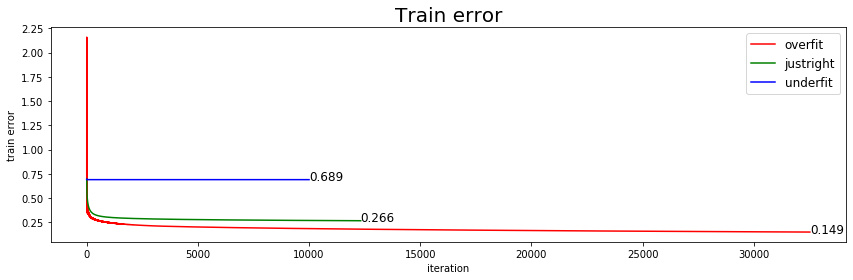

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(model_overfit.record_cost, 'r-', label='overfit')
plt.plot(model_justright.record_cost, 'g-', label='justright')
plt.plot(model_underfit.record_cost, 'b-', label='underfit')

plt.title('Train error', fontsize=20)
plt.xlabel('iteration')
plt.ylabel('train error')
plt.legend(loc='best', fontsize=12)

plt.text(len(model_overfit.record_cost), model_overfit.record_cost[-1]-0.01,
         '{}'.format(round(model_overfit.record_cost[-1], 3)), fontsize=12)
plt.text(len(model_justright.record_cost), model_justright.record_cost[-1]-0.01,
         '{}'.format(round(model_justright.record_cost[-1], 3)), fontsize=12)
plt.text(len(model_underfit.record_cost), model_underfit.record_cost[-1]-0.01,
         '{}'.format(round(model_underfit.record_cost[-1], 3)), fontsize=12)

plt.tight_layout()
plt.show()

# 3. Display the values of the chosen regularization parameters

In [15]:
from colorama import Fore, Back, Style 

print(Fore.RED + '모델이 over-fitting이 되려면 parameter인 세타에 규제가 없어야 하므로 {}이 되야 한다.'.format(alpha_overfit))
print(Style.RESET_ALL)
print(Fore.GREEN + '모델이 justright-fitting이 되려면 parameter인 세타에 약간의 규제가 있어야 하므로 {}로 선택했다.'
      .format(alpha_justright))
print(Style.RESET_ALL)
print(Fore.BLUE + '모델이 under-fitting이 되려면 parameter인 세타에 규제가 많아야 하므로 {}정도로 큰 숫자를 선택했다.'
      .format(alpha_underfit))
print(Style.RESET_ALL)

모델이 over-fitting이 되려면 parameter인 세타에 규제가 없어야 하므로 0이 되야 한다.

모델이 justright-fitting이 되려면 parameter인 세타에 약간의 규제가 있어야 하므로 0.0001로 선택했다.

모델이 under-fitting이 되려면 parameter인 세타에 규제가 많아야 하므로 100정도로 큰 숫자를 선택했다.



# 4. Plot the training accuracy with varying regularization parameters

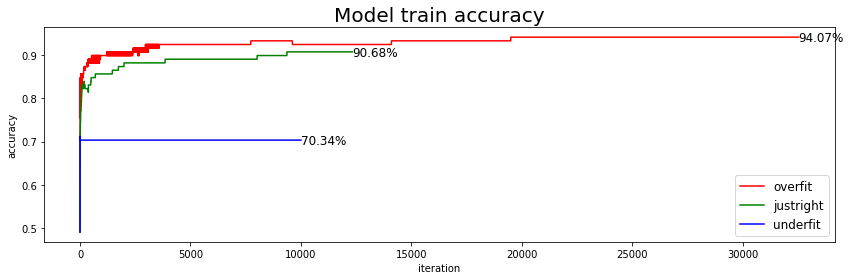

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(model_overfit.record_accuracy, 'r-', label='overfit')
plt.plot(model_justright.record_accuracy, 'g-', label='justright')
plt.plot(model_underfit.record_accuracy, 'b-', label='underfit')

plt.title('Model train accuracy', fontsize=20)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.legend(loc='best', fontsize=12)

plt.text(len(model_overfit.record_accuracy), model_overfit.record_accuracy[-1]-0.01,
         '{}%'.format(100*round(model_overfit.record_accuracy[-1], 4)), fontsize=12)
plt.text(len(model_justright.record_accuracy), model_justright.record_accuracy[-1]-0.01,
         '{}%'.format(100*round(model_justright.record_accuracy[-1], 4)), fontsize=12)
plt.text(len(model_underfit.record_accuracy), model_underfit.record_accuracy[-1]-0.01,
         '{}%'.format(100*round(model_underfit.record_accuracy[-1], 4)), fontsize=12)

plt.tight_layout()
plt.show()

# 5. Display the final training accuracy with varying regularization parameters

In [17]:
print(Fore.RED+'model over-fitting : lambda가 {}일 때 final training accuracy는 {}%이다.'.format(alpha_overfit,
                                                                        100*round(model_overfit.record_accuracy[-1], 4)))
print(Style.RESET_ALL)
print(Fore.GREEN+'model justright-fitting : lambda가 {}일 때 final training accuracy는 {}%이다.'.format(alpha_justright,
                                                                        100*round(model_justright.record_accuracy[-1], 4)))
print(Style.RESET_ALL)
print(Fore.BLUE+'model under-fitting : lambda가 {}일 때 final training accuracy는 {}%이다.'.format(alpha_underfit,
                                                                        100*round(model_underfit.record_accuracy[-1], 4)))
print(Style.RESET_ALL)

model over-fitting : lambda가 0일 때 final training accuracy는 94.07%이다.

model justright-fitting : lambda가 0.0001일 때 final training accuracy는 90.68%이다.

model under-fitting : lambda가 100일 때 final training accuracy는 70.34%이다.



# 6. Plot the optimal classifier with varying regularization parameters superimposed on the training data

In [18]:
# make x_grid, y_grid, z_grid

x_linspace = np.linspace(-1, 1.2, 300)
y_linspace = np.linspace(-1, 1.2, 300)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)

overfit_z_grid = np.zeros(x_grid.shape)
justright_z_grid = np.zeros(x_grid.shape)
underfit_z_grid =  np.zeros(x_grid.shape)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        temp = np.array([x_grid[i, j], y_grid[i, j]]).reshape(1, 2)
        temp_poly = polynomial.transform(temp)
        temp_poly_scaled = scaler.transform(temp_poly)
        
        overfit_z_grid[i, j] = model_overfit.sigmoid(temp_poly_scaled, model_overfit.coef_.reshape(-1, 1))
        justright_z_grid[i, j] = model_justright.sigmoid(temp_poly_scaled, model_justright.coef_.reshape(-1, 1))
        underfit_z_grid[i, j] = model_underfit.sigmoid(temp_poly_scaled, model_underfit.coef_.reshape(-1, 1))

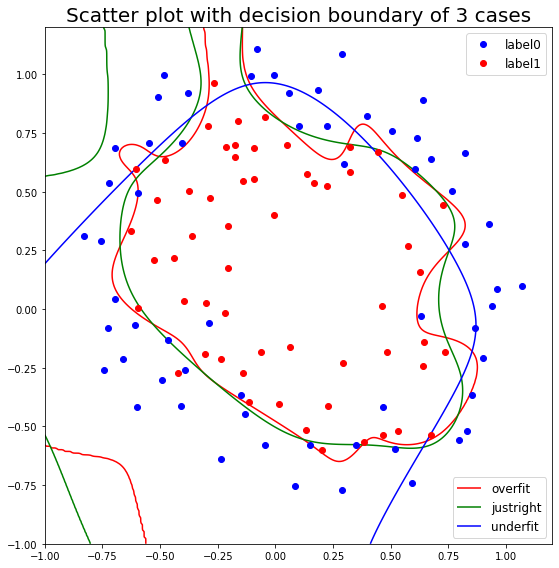

In [19]:
# scatter plot with decision boundary of 3 cases
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot(label_0.x, label_0.y, 'bo', label='label0')
ax.plot(label_1.x, label_1.y, 'ro', label='label1')
contour1 = ax.contour(x_grid, y_grid, overfit_z_grid, levels=[0.5], colors='red')
contour2 = ax.contour(x_grid, y_grid, justright_z_grid, levels=[0.5], colors='green')
contour3 = ax.contour(x_grid, y_grid, underfit_z_grid, levels=[0.5], colors='blue')

legend1 = ax.legend(loc='upper right', fontsize=12)

c1, _ = contour1.legend_elements()
c2, _ = contour2.legend_elements()
c3, _ = contour3.legend_elements()
legend2 = ax.legend([c1[0], c2[0], c3[0]], ['overfit', 'justright', 'underfit'],loc='lower right', fontsize=12)

ax.add_artist(legend1)

plt.title('Scatter plot with decision boundary of 3 cases', fontsize=20)
plt.tight_layout()
plt.show()